In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as ac 
from astroquery.splatalogue import Splatalogue
import astropy.units as u
from helpers import generate_smart_table, LTEmodel, get_CDMS_partition_function

ckms = ac.c.to(u.km/u.s).value


In [6]:
# lines of interest
specie = [
    "HOCO+"
]  # spaces are needed to specify the particular ones

# frequency range of interest 
nu_range = (80 * u.GHz, 100 * u.GHz)

line_query = {}
specie_id = {}
pf = {}
for s in specie:
    if s == "NH3":
        chemical_name = " NH3 v=0 "
        pf_name = "NH3-wHFS"
    else:
        chemical_name = "{:s}".format(s)
        pf_name = s
    q = Splatalogue.query_lines(
        *nu_range,
        chemical_name=chemical_name,
        line_lists=["JPL"],
        show_upper_degeneracy=True,
        # line_strengths=["ls4"],
        # energy_type="eu_k",
    )
    # id = Splatalogue.get_species_ids(chemical_name)
    # specie_id[s] = id
    line_query[s] = generate_smart_table(q)
    pf[s] = get_CDMS_partition_function(pf_name)
line_query

[1000.     500.     300.     225.     150.      75.      37.5     18.75
    9.375    5.       2.725] [          nan           nan 2943.0659897  1907.65572399 1036.57325677
  366.10022855  129.59850748   46.69818486   19.26193886   10.09485302
    5.65718003]


{'HOCO+': <Table length=7>
 Species      QNs      nu0 [GHz]  logA [s^-1] Smu2 [D^2]   g_u    E_u [K] 
   str5      str13      float64     float64    float64   float64  float64 
 ------- ------------- ---------- ----------- ---------- ------- ---------
   HOCO+ 4(1,4)-3(1,3) 85.1956703    -4.92098   14.99954     9.0   47.5663
   HOCO+ 4(3,2)-3(3,1) 85.4663391    -5.24789    6.99898     9.0 342.47334
   HOCO+ 4(3,2)-3(3,1) 85.4663391    -5.24789    6.99898     9.0 342.47334
   HOCO+ 4(2,3)-3(2,2) 85.5022531    -5.01323    11.9991     9.0 158.98947
   HOCO+ 4(2,2)-3(2,1) 85.5025062    -5.01323   11.99903     9.0 158.98949
   HOCO+ 4(0,4)-3(0,3) 85.5315123    -4.88788   15.99727     9.0   10.2622
   HOCO+ 4(1,3)-3(1,2) 85.8528576    -4.91095   15.00012     9.0  47.64517}

In [30]:
# assume L483 abundance

N = {"HOCO+": 3.1e13}

Tex = 10
DeltaV = 0.5

# beam = 0.5 * u.arcsec # in arcsec
# source_size = 0.7 * u.arcsec # in arcsec
# f = source_size ** 2 / (source_size ** 2 + beam ** 2)
# beam_area = np.pi / (4 * np.log(2)) * beam ** 2

f = 1

# axis
nu_min = nu_range[0].value*1e9
nu_max = nu_range[1].value*1e9
dnu = nu_min / ckms * DeltaV / 5.0
nu = np.arange(nu_min, nu_max, dnu)

I_all = {}
tau_all = {}
for s in specie:
    I_all_s = 0
    tau_all_s = 0
    for trans in line_query[s]:
        I, t = LTEmodel(
            nu=nu,
            nu0=trans["nu0 [GHz]"] * 1e9,
            g_u=trans["g_u"],
            E_u=trans["E_u [K]"],
            A_ul=10 ** trans["logA [s^-1]"],
            N=N[s],
            Tex=Tex,
            DeltaV=DeltaV,
            f=f,
            Q=pf[s](Tex),
        )

        

        I_all_s += I.to(u.Jy/u.sr)
        tau_all_s += t
    # I_all[s] = I_all_s.to(u.mJy/u.beam, equivalencies=u.beam_angular_area(beam_area))
    I_all[s] = I_all_s.to(u.K, equivalencies=u.brightness_temperature(nu*u.Hz))
    tau_all[s] = tau_all_s
I_all

{'HOCO+': <Quantity [0., 0., 0., ..., 0., 0., 0.] K>}

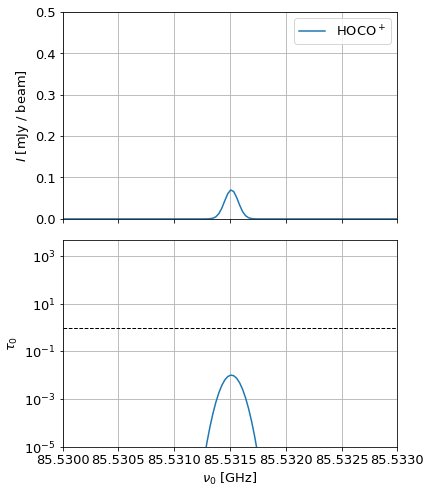

In [33]:
import matplotlib.pyplot as plt
from matplotlib import ticker

plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

xlim = (85.53, 85.533)
#xlim = (306, 306.1)
color = {'NH3': 'tab:blue',
         'NH2D': 'tab:orange',
         'NHD2': 'tab:purple',
         "ND3": "tab:green"}

label = {'HOCO+': 'HOCO$^+$'}

for s in specie:
    # intenisty
    ax[0].plot(nu*1e-9, I_all[s], label=label[s])
    ax[0].grid()
    ax[0].set(xlim=xlim, ylim=(0, 0.5), ylabel=r'$I$ [mJy / beam]')
    #ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    #ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(1.0))
    ax[0].legend()
    
    # tau
    ax[1].plot(nu*1e-9, tau_all[s])
    ax[1].grid()
    ax[1].axhline(y=1.0, color='black', ls='--', lw=1.0)
    ax[1].set(xlim=xlim, xlabel=r'$\nu_0$ [GHz]', ylabel=r'$\tau_0$', yscale='log', ylim=(1e-5, 5e3))

plt.subplots_adjust(hspace=0.1)

In [11]:
np.max(I_all["HOCO+"])

<Quantity 0.00576485 mJy / beam>

In [98]:
nu = 85.5315 * u.GHz
A_ul = 0.0000235964 / u.s
g_u = 9
E_u = 10.26 * u.K
DeltaV = 0.5 * u.km/u.s

import astropy.constants as ac

ckms = ac.c.to(u.cm/u.s)
ccms = ac.c.to(u.km/u.s)
c = ac.c
h = ac.h
k = ac.k_B

Tex = 50 * u.K

Q = pf[s](Tex)

N = 3.1e13 / u.cm**2

print(Q)

Deltanu = nu / c * DeltaV
phi = np.sqrt(4 * np.log(2) / np.pi) / Deltanu

N_u = N / Q * g_u * np.exp(-E_u / Tex)
print(N_u)

tau = (
    c ** 2
    / (8 * np.pi * nu ** 2)
    * (np.exp(h * nu / (k * Tex)) - 1.0)
    * A_ul
    * phi
    * N_u
)
print(tau.decompose())

Tex * (1 - np.exp(-tau))

199.4215764187394
1139501314676.2205 1 / cm2
0.07405942528305316


<Quantity 3.56917455 K>

In [69]:
50 * 0.035

1.7500000000000002

In [64]:
10**(-4.88788)

1.2945534903849694e-05

In [88]:
(h*200*u.GHz/k).to(u.K)

<Quantity 9.59848615 K>

In [93]:
np.exp(h * nu / (k * 50*u.K)) - 1.0

<Quantity 0.2780083>